In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
paths_to_performances = [
    {
        "hitl_iteration": 2,
        "cv_iteration": 0,
        "path": Path.cwd() / 'resources' / 'HITL-iteration-2-from-iteration-1' / 'model-selection' / 'validation_performance_cv_fold_1_MedSAM-ViT-B-20240808-0200.json'
    },
    {
        "hitl_iteration": 2,
        "cv_iteration": 1,
        "path": Path.cwd() / 'resources' / 'HITL-iteration-2-from-iteration-1' / 'model-selection' / 'validation_performance_cv_fold_2_MedSAM-ViT-B-20240808-0430.json'
    },
    {
        "hitl_iteration": 2,
        "cv_iteration": 2,
        "path": Path.cwd() / 'resources' / 'HITL-iteration-2-from-iteration-1' / 'model-selection' / 'validation_performance_cv_fold_3_MedSAM-ViT-B-20240808-0700.json'
    },
    {
        "hitl_iteration": 2,
        "cv_iteration": 3,
        "path": Path.cwd() / 'resources' / 'HITL-iteration-2-from-iteration-1' / 'model-selection' / 'validation_performance_cv_fold_4_MedSAM-ViT-B-20240808-0930.json'
    }
]
paths_to_splits = [
    {
        "hitl_iteration": 2,
        "path": Path.cwd() / 'resources' / 'HITL-iteration-2-from-iteration-1' / 'model-selection' / 'splits.csv'
    }
]

In [3]:
pd.set_option('display.max_colwidth', None)
#pd.reset_option('display.max_colwidth')

# Obtención de modelos: Validación Cruzada
Se propone una Validación Cruzada de tipo **Leave One Patient Out (LOPO)** para seleccionar el mejor modelo después de cada época de entrenamiento. Se obtiene un modelo para fold de la Validación Cruzada. Todos los modelos obtenidos pasan a ser evaluados sobre el conjunto de test. 

## Iteración 1

- Se tiene un conjunto de entrenamiento con **13 volúmenes CT** anotados por los becados, y corregidos por los radiólogos GP y MF, correspondientes a **4 pacientes**:
    - 1: cáncer gástrico (1 estudio, 2 series anotadas)
    - 2: cáncer gástrico (4 estudios, 6 series anotadas)
    - 3: cáncer de mama (2 estudios, 3 series anotadas)
    - 14: cáncer de pulmón (1 estudio, 2 series anotadas)

## Iteración 2

- Se tiene un conjunto de entrenamiento con **11 volúmenes CT** anotados por los becados, y corregidos por los radiólogos GP y MF, correspondientes a **4 pacientes**:
    - 6: cáncer de colon (3 estudios, 6 series anotadas)
    - 10972: cáncer gástrico (1 estudio, 1 serie anotada)
    - 10973: cáncer de recto (3 estudios, 3 series anotadas)
    - 10974: cáncer de colon (1 estudio, 1 series anotada)

In [4]:
# Read splits csv
path_to_splits_it1 = [item["path"] for item in paths_to_splits if item['hitl_iteration'] == paths_to_performances[0]['hitl_iteration']][0]
splits_it1_df = pd.read_csv(path_to_splits_it1)
display(splits_it1_df)

,filename,series_uuid,slice_idx,patient_code,cv_iteration,subset
0,145_1.3.12.2.1107.5.1.4.83504.30000021011202081810900016917.npy,1.3.12.2.1107.5.1.4.83504.30000021011202081810900016917,145,6,0,train
1,185_1.3.12.2.1107.5.1.4.83504.30000021011202081810900017615.npy,1.3.12.2.1107.5.1.4.83504.30000021011202081810900017615,185,6,0,train
2,130_1.3.12.2.1107.5.1.4.83504.30000021011202081810900016917.npy,1.3.12.2.1107.5.1.4.83504.30000021011202081810900016917,130,6,0,train
3,157_1.3.12.2.1107.5.1.4.83504.30000021011202081810900017615.npy,1.3.12.2.1107.5.1.4.83504.30000021011202081810900017615,157,6,0,train
4,129_1.3.12.2.1107.5.1.4.83504.30000021031714114711900009018.npy,1.3.12.2.1107.5.1.4.83504.30000021031714114711900009018,129,6,0,train
...,...,...,...,...,...,...
1523,153_1.3.12.2.1107.5.1.4.83504.30000020121611411612500007509.npy,1.3.12.2.1107.5.1.4.83504.30000020121611411612500007509,153,10972,3,train
1524,151_1.3.12.2.1107.5.1.4.83504.30000020102916421550900016665.npy,1.3.12.2.1107.5.1.4.83504.30000020102916421550900016665,151,6,3,validation
1525,143_1.3.12.2.1107.5.1.4.83504.30000020102916421550900015953.npy,1.3.12.2.1107.5.1.4.83504.30000020102916421550900015953,143,6,3,validation
1526,163_1.3.12.2.1107.5.1.4.83504.30000021052612201586400049605.npy,1.3.12.2.1107.5.1.4.83504.30000021052612201586400049605,163,10973,3,train


In [5]:
# Validation patient for each fold
validation_patients = splits_it1_df[splits_it1_df['subset'] == 'validation'].groupby(['cv_iteration'])['patient_code'].unique().reset_index()
display(validation_patients)

,cv_iteration,patient_code
0,0,[10972]
1,1,[10973]
2,2,[10974]
3,3,[6]


In [6]:
# Annotated slices for each series and patient
grouped = splits_it1_df.groupby(['patient_code', 'series_uuid']).size()
grouped = grouped.reset_index(name='annotated_slices')
display(grouped)

,patient_code,series_uuid,annotated_slices
0,6,1.3.12.2.1107.5.1.4.83504.30000020102916421550900015953,64
1,6,1.3.12.2.1107.5.1.4.83504.30000020102916421550900016665,180
2,6,1.3.12.2.1107.5.1.4.83504.30000021011202081810900016917,128
3,6,1.3.12.2.1107.5.1.4.83504.30000021011202081810900017615,200
4,6,1.3.12.2.1107.5.1.4.83504.30000021031714114711900009018,128
5,6,1.3.12.2.1107.5.1.4.83504.30000021031714114711900009696,188
6,10972,1.3.12.2.1107.5.1.4.83504.30000020121611411612500007509,244
7,10973,1.3.12.2.1107.5.1.4.83504.30000021052612201586400049605,108
8,10973,1.3.12.2.1107.5.1.4.83504.30000021080212120090000010256,128
9,10973,1.3.12.2.1107.5.1.4.83504.30000021100712273932400016978,136


In [7]:
# Annotated slices per patient
grouped = splits_it1_df.groupby(['patient_code'])['series_uuid'].size()
grouped = grouped.reset_index(name='annotated_slices')
display(grouped)

,patient_code,annotated_slices
0,6,888
1,10972,244
2,10973,372
3,10974,24


In [8]:
# Annotated series per patient
grouped = splits_it1_df.groupby('patient_code')['series_uuid'].nunique()
grouped = grouped.reset_index(name='annotated_series')
display(grouped)

,patient_code,annotated_series
0,6,6
1,10972,1
2,10973,3
3,10974,1


In [9]:
# Annotated series for each cv iteration and subset
grouped = splits_it1_df.groupby(['cv_iteration', 'subset'])['series_uuid'].nunique()
grouped = grouped.reset_index(name='annotated_series')
display(grouped)

,cv_iteration,subset,annotated_series
0,0,train,10
1,0,validation,1
2,1,train,8
3,1,validation,3
4,2,train,10
5,2,validation,1
6,3,train,5
7,3,validation,6


In [10]:
# Annotated series per patient, for each cv iteration and subset
grouped = splits_it1_df.groupby(['cv_iteration', 'subset', 'patient_code'])['series_uuid'].nunique()
grouped = grouped.reset_index(name='annotated_series')
display(grouped)

,cv_iteration,subset,patient_code,annotated_series
0,0,train,6,6
1,0,train,10973,3
2,0,train,10974,1
3,0,validation,10972,1
4,1,train,6,6
5,1,train,10972,1
6,1,train,10974,1
7,1,validation,10973,3
8,2,train,6,6
9,2,train,10972,1


In [11]:
# Read validation performances
it1_items = [item for item in paths_to_performances if item["hitl_iteration"] == paths_to_performances[0]['hitl_iteration']]
val_performances_it1 = pd.DataFrame()
for item in it1_items:
    with open(item['path'], 'r') as file:
        df = pd.DataFrame(json.load(file))
    df['cv_iteration'] = item['cv_iteration']
    val_performances_it1 = pd.concat([val_performances_it1, df])
display(val_performances_it1)

,epoch,batch_idx,loss,mean_dice_score,cv_iteration
0,0,0,0.065424,0.915216,0
1,0,1,0.067834,0.909754,0
2,0,2,0.181614,0.764306,0
3,0,3,0.102284,0.869693,0
4,0,4,0.174474,0.774343,0
...,...,...,...,...,...
11095,49,217,0.294931,0.666667,3
11096,49,218,0.081942,0.891935,3
11097,49,219,0.088425,0.882906,3
11098,49,220,0.130845,0.842482,3


In [12]:
# Plot mean dice score for each epoch and cv iteration
mean_std_df = val_performances_it1.groupby(['cv_iteration', 'epoch'])['mean_dice_score'].agg(['mean', 'std']).reset_index()
display(mean_std_df)

,cv_iteration,epoch,mean,std
0,0,0,0.845179,0.120193
1,0,1,0.847771,0.076227
2,0,2,0.843888,0.070380
3,0,3,0.838950,0.097766
4,0,4,0.839531,0.064990
...,...,...,...,...
195,3,45,0.721355,0.196645
196,3,46,0.720191,0.196628
197,3,47,0.719472,0.198770
198,3,48,0.722104,0.191421


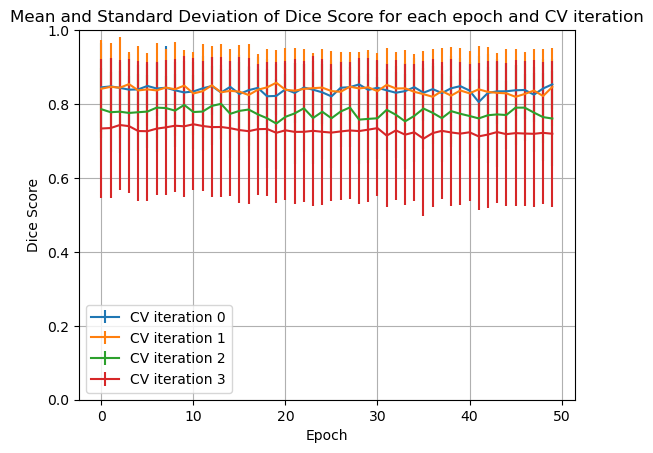

In [13]:
# Mean and std
for cv_iter in mean_std_df['cv_iteration'].unique():
    cv_iter_df = mean_std_df[mean_std_df['cv_iteration'] == cv_iter]
    plt.errorbar(cv_iter_df['epoch'], cv_iter_df['mean'], yerr=cv_iter_df['std'], label=f'CV iteration {cv_iter}')
plt.xlabel('Epoch')
plt.ylabel('Dice Score')
plt.title('Mean and Standard Deviation of Dice Score for each epoch and CV iteration')
plt.legend()
plt.ylim((0, 1.0))
plt.grid(True)
plt.show()

#for cv_iter in mean_std_df['cv_iteration'].unique():
#    cv_iter_df = mean_std_df[mean_std_df['cv_iteration'] == cv_iter]
#    plt.errorbar(cv_iter_df['epoch'], cv_iter_df['mean'], yerr=cv_iter_df['std'], label=f'CV iteration {cv_iter}')
#    plt.xlabel('Epoch')
#    plt.ylabel('Dice Score')
#    plt.title('Mean and Standard Deviation of Dice Score for each epoch and CV iteration')
#    plt.ylim((0, 1.0))
#    plt.legend()
#    plt.grid(True)
#    plt.show()

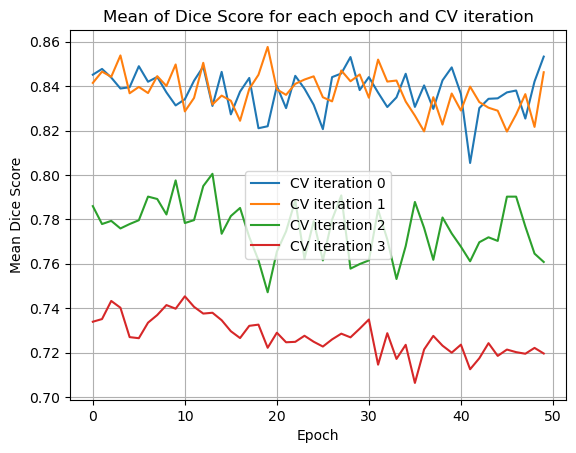

In [14]:
# Mean
for cv_iter in mean_std_df['cv_iteration'].unique():
    cv_iter_df = mean_std_df[mean_std_df['cv_iteration'] == cv_iter]
    plt.plot(cv_iter_df['epoch'], cv_iter_df['mean'], label=f'CV iteration {cv_iter}')

plt.xlabel('Epoch')
plt.ylabel('Mean Dice Score')
plt.title('Mean of Dice Score for each epoch and CV iteration')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
display(mean_std_df.loc[mean_std_df.groupby('cv_iteration')['mean'].idxmax()])

,cv_iteration,epoch,mean,std
49,0,49,0.853322,0.067631
69,1,19,0.857687,0.087914
113,2,13,0.800536,0.095602
160,3,10,0.745337,0.178532
